# Overview

This notebook analysis will test if a natural language processing can detect fraud in job postings. The dataset contains a substantial amount of data. Creating a single neural network that will take all that data as an input is challenging. Numeric, categorical, and textual information are all fed differently into a neural network. We will attempt to simplify the problem by breaking it up into multiple stages. The diagram below shows the suggested architecture for the analysis.

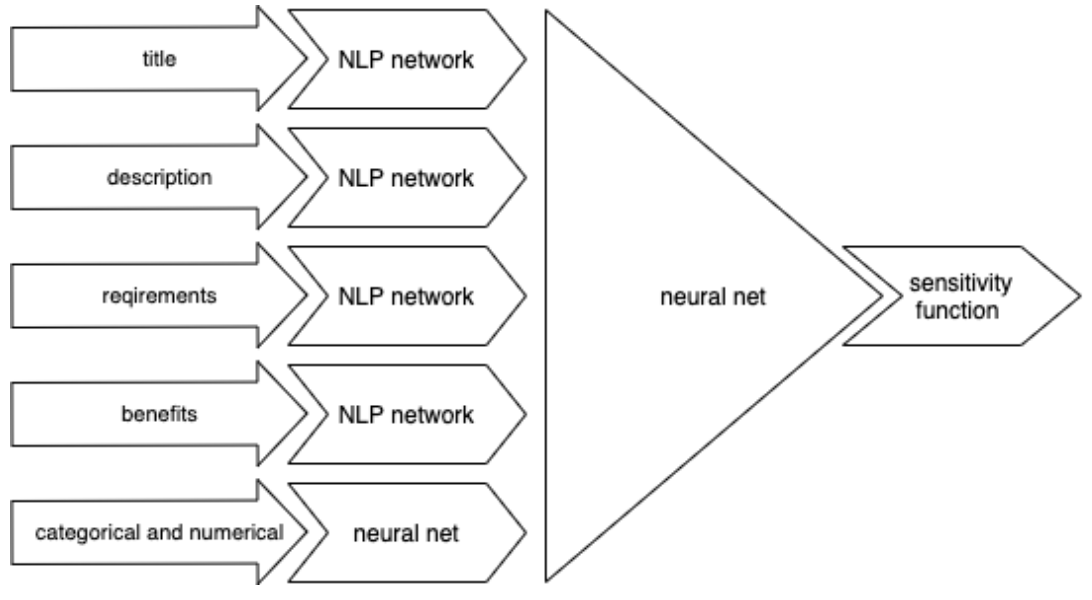

On the left-hand side, you can see the input data. Each textual input will be fed into its neural network. All the other numeric and categorical variables will be fed into a single network. Each network will be trained independently to achieve an optimal accuracy score.
 
The output from each network will then be fed into another independent neural network that will attempt to combine the output from the previous networks to achieve an even higher accuracy score.



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# read the csv into a pandas dataframe
df = pd.read_csv('/kaggle/input/recruitment-scam/DataSet.csv')

pd.set_option('display.max_columns', None)
df

In [ ]:
# select a balanced set
df = df[df['in_balanced_dataset'] == 't']

In [ ]:
target_value = "fraudulent"

In [ ]:
df = df.drop(['in_balanced_dataset'], axis=1)

In [ ]:
def extractComponent(index, value):
    if isinstance(value, str):
        items = [item.strip() for item in value.split(',')]
        return np.nan if len(items) <= index or len(items[index]) == 0 else items[index]
    else:
        return np.nan

In [ ]:
# break location into country state and city
df['country'] = df['location'].apply(lambda x: extractComponent(0, x))
df['state'] = df['location'].apply(lambda x: extractComponent(1, x))
df['city'] = df['location'].apply(lambda x: extractComponent(2, x))
df = df.drop(['location'], axis=1)

In [ ]:
df

In [ ]:
print("country:" + str(len(df['country'].unique())))
print("state:" + str(len(df['state'].unique())))
print("city:" + str(len(df['city'].unique())))
print("department:" + str(len(df['department'].unique())))
print("employment_type:" + str(len(df['employment_type'].unique())))
print("required_experience:" + str(len(df['required_experience'].unique())))
print("industry:" + str(len(df['industry'].unique())))

In [ ]:
# We will drop all categorical values that have too many options (above one percent of dataset)
df = df.drop(['state', 'city', 'department'], axis=1)

In [ ]:
df['employment_type'].apply(lambda x: str(x)).value_counts().plot(kind='bar')

In [ ]:
df['required_experience'].apply(lambda x: str(x)).value_counts().plot(kind='bar')

In [ ]:
# print all chars used in title
chars = set()
for index, value in df.title.items():
    if isinstance(value, str):
        chars.update(set(value))
print(chars)

In [ ]:
# let's examin all titles that contain any of these chars: +*#%&?@[]()\|~
for index, value in df.title.items():
    if isinstance(value, str):
        if (not set(value).isdisjoint(set("+*#%&?@[]()\|~."))):
            print(value)

In [ ]:
def percentage_of_caps(value):
    if isinstance(value, str):
        caps_count = len(re.findall(r'[A-Z]',value))
        lower_case_count = len(re.findall(r'[a-z]',value))
        return 0 if caps_count == 0 else (caps_count / float(caps_count + lower_case_count))
    else:
        0

In [ ]:
df['title_caps'] = df['title'].apply(lambda x: percentage_of_caps(x))
df['title_caps'].hist(bins=40)

In [ ]:
def has_parentheses(value):
    if isinstance(value, str):
        if len(re.findall(r'[\(\)\[\]]',value)) == 0:
            return False
        else:
            return True
    else:
        return False

In [ ]:
df['title_parentheses'] = df['title'].apply(lambda x: has_parentheses(x))
df['title_parentheses'].apply(lambda x: str(x)).value_counts().plot(kind='bar')

In [ ]:
# parse <number>-<number> for salary range
def get_range(upper, value):
    if isinstance(value, str):
        items = [item.strip() for item in value.split('-')]
        if len(items) == 1:
            return float(items[0])
        return float(items[1 if upper else 0])
    else:
        return np.nan

In [ ]:
df['salary_range'].apply(lambda x: get_range(False, x)).dropna().hist(bins=10)

In [ ]:
# examin log (plus one to avoid no log of zero)
df['salary_range'].apply(lambda x: get_range(False, x)).dropna().apply(lambda x: np.log10(x + 1)).hist(bins=100)

In [ ]:
df['salary_range'].apply(lambda x: get_range(True, x)).dropna().apply(lambda x: np.log10(x + 1)).hist(bins=100)

In [ ]:
df['salary_upper_log_norm'] = df['salary_range']\
    .apply(lambda x: get_range(False, x))\
    .apply(lambda x: np.log10(x + 1))\
    .apply(lambda x: min(x / 10.0, 1.0)) # data is in the range 0 - 10
    
df['salary_upper_log_norm'] = df['salary_range']\
    .apply(lambda x: get_range(False, x))\
    .apply(lambda x: np.log10(x + 1))\
    .apply(lambda x: min(x / 10.0, 1.0)) # data is in the range 0 - 10
    
df = df.drop(['salary_range'], axis=1)

In [ ]:
df

In [ ]:
df['telecommuting'].apply(lambda x: str(x)).value_counts().plot(kind='bar')
df['telecommuting'] = df['telecommuting'].apply(lambda x: True if x == 't' else False)

In [ ]:
df['has_company_logo'].apply(lambda x: str(x)).value_counts().plot(kind='bar')
df['has_company_logo'] = df['has_company_logo'].apply(lambda x: True if x == 't' else False)

In [ ]:
df['has_questions'].apply(lambda x: str(x)).value_counts().plot(kind='bar')
df['has_questions'] = df['has_questions'].apply(lambda x: True if x == 't' else False)

In [ ]:
df['fraudulent'].apply(lambda x: str(x)).value_counts().plot(kind='bar')
df['fraudulent'] = df['fraudulent'].apply(lambda x: True if x == 't' else False)

In [ ]:
from IPython.core.display import display, HTML
#display(HTML(df['description'][7]))

In [ ]:
#df['description'][7]

In [ ]:
def bullet_count(value):
    if isinstance(value, str):
        matches = re.findall(r'\<li\>',value)
        return len(matches)
    else:
        return 0

In [ ]:
df['description'].apply(lambda x: np.log10(1 + bullet_count(x))).hist(bins=25)

In [ ]:
df['company_profile'].apply(lambda x: np.log10(1 + bullet_count(x))).hist(bins=25)

In [ ]:
df['requirements'].apply(lambda x: np.log10(1 + bullet_count(x))).hist(bins=25)

In [ ]:
df['benefits'].apply(lambda x: np.log10(1 + bullet_count(x))).hist(bins=25)

In [ ]:
df['description_bullet_cnt_norm'] = df['description']\
    .apply(lambda x: np.log10(1 + bullet_count(x)))\
    .apply(lambda x: min(x / 2.0, 1.0)) # data is in the range 0 - 2
    
df['company_profile_bullet_cnt_norm'] = df['company_profile']\
    .apply(lambda x: np.log10(1 + bullet_count(x)))\
    .apply(lambda x: min(x / 2.0, 1.0)) # data is in the range 0 - 2
    
df['requirements_bullet_cnt_norm'] = df['requirements']\
    .apply(lambda x: np.log10(1 + bullet_count(x)))\
    .apply(lambda x: min(x / 2.0, 1.0)) # data is in the range 0 - 2
    
df['benefits_bullet_cnt_norm'] = df['benefits']\
    .apply(lambda x: np.log10(1 + bullet_count(x)))\
    .apply(lambda x: min(x / 2.0, 1.0)) # data is in the range 0 - 2

In [ ]:
def paragraph_count(value):
    if isinstance(value, str):
        matches = re.findall(r'\<p\>',value)
        return len(matches)
    else:
        return 0

In [ ]:
df['description_paragraph_cnt_norm'] = df['description']\
    .apply(lambda x: np.log10(1 + paragraph_count(x)))\
    .apply(lambda x: min(x / 2.0, 1.0)) # data is in the range 0 - 2
    
df['company_profile_paragraph_cnt_norm'] = df['company_profile']\
    .apply(lambda x: np.log10(1 + paragraph_count(x)))\
    .apply(lambda x: min(x / 2.0, 1.0)) # data is in the range 0 - 2
    
df['requirements_paragraph_cnt_norm'] = df['requirements']\
    .apply(lambda x: np.log10(1 + paragraph_count(x)))\
    .apply(lambda x: min(x / 2.0, 1.0)) # data is in the range 0 - 2
    
df['benefits_paragraph_cnt_norm'] = df['benefits']\
    .apply(lambda x: np.log10(1 + paragraph_count(x)))\
    .apply(lambda x: min(x / 2.0, 1.0)) # data is in the range 0 - 2

In [ ]:
def bold_count(value):
    if isinstance(value, str):
        matches = re.findall(r'\<b\>',value)
        return len(matches)
    else:
        return 0

In [ ]:
df['description_bold_cnt_norm'] = df['description']\
    .apply(lambda x: np.log10(1 + bold_count(x)))\
    .apply(lambda x: min(x / 2.0, 1.0)) # data is in the range 0 - 2
    
df['company_profile_bold_cnt_norm'] = df['company_profile']\
    .apply(lambda x: np.log10(1 + bold_count(x)))\
    .apply(lambda x: min(x / 2.0, 1.0)) # data is in the range 0 - 2
    
df['requirements_bold_cnt_norm'] = df['requirements']\
    .apply(lambda x: np.log10(1 + bold_count(x)))\
    .apply(lambda x: min(x / 2.0, 1.0)) # data is in the range 0 - 2
    
df['benefits_bold_cnt_norm'] = df['benefits']\
    .apply(lambda x: np.log10(1 + bold_count(x)))\
    .apply(lambda x: min(x / 2.0, 1.0)) # data is in the range 0 - 2

In [ ]:
# will replace with ^XYZ^ as it will not conflict with any HTML
def dropSha2(prefix, value):
    if isinstance(value, str):
        return re.sub(r"#" + prefix + "_[A-Za-z0-9]{10,128}#", "^" + prefix + "^", value)
    else:
        return value

In [ ]:
df['description'] = df['description'].apply(lambda x: dropSha2('URL', x))
df['company_profile'] = df['company_profile'].apply(lambda x: dropSha2('URL', x))
df['requirements'] = df['requirements'].apply(lambda x: dropSha2('URL', x))
df['benefits'] = df['benefits'].apply(lambda x: dropSha2('URL', x))

df['description'] = df['description'].apply(lambda x: dropSha2('PHONE', x))
df['company_profile'] = df['company_profile'].apply(lambda x: dropSha2('PHONE', x))
df['requirements'] = df['requirements'].apply(lambda x: dropSha2('PHONE', x))
df['benefits'] = df['benefits'].apply(lambda x: dropSha2('PHONE', x))

df['description'] = df['description'].apply(lambda x: dropSha2('EMAIL', x))
df['company_profile'] = df['company_profile'].apply(lambda x: dropSha2('EMAIL', x))
df['requirements'] = df['requirements'].apply(lambda x: dropSha2('EMAIL', x))
df['benefits'] = df['benefits'].apply(lambda x: dropSha2('EMAIL', x))

In [ ]:
# because URLs can be embeded into text with <a href="^URL^"> we will create additional variable for
# the count of URLS in each category

In [ ]:
def url_count(value):
    if isinstance(value, str):
        matches = re.findall(r'\^URL\^',value)
        return len(matches)
    else:
        return 0

In [ ]:
df['description'].apply(lambda x: np.log10(1 + url_count(x))).hist(bins=25)

In [ ]:
df['description_url_cnt_norm'] = df['description']\
    .apply(lambda x: np.log10(1 + url_count(x)))\
    .apply(lambda x: min(x / 2.0, 1.0)) # data is in the range 0 - 2
    
df['company_profile_url_cnt_norm'] = df['company_profile']\
    .apply(lambda x: np.log10(1 + url_count(x)))\
    .apply(lambda x: min(x / 2.0, 1.0)) # data is in the range 0 - 2
    
df['requirements_url_cnt_norm'] = df['requirements']\
    .apply(lambda x: np.log10(1 + url_count(x)))\
    .apply(lambda x: min(x / 2.0, 1.0)) # data is in the range 0 - 2
    
df['benefits_bold_url_norm'] = df['benefits']\
    .apply(lambda x: np.log10(1 + url_count(x)))\
    .apply(lambda x: min(x / 2.0, 1.0)) # data is in the range 0 - 2

In [ ]:
#HTML(df['description'][7])

In [ ]:
# Eloff 2019: https://stackoverflow.com/a/925630 
from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    if isinstance(html, str):
        s = MLStripper()
        s.feed(html)
        return s.get_data()\
            .replace(u'\xa0', u' ') # remove non breaking space
    else:
        return html

In [ ]:
df['description'] = df['description'].apply(lambda x: strip_tags(x))
df['company_profile'] = df['company_profile'].apply(lambda x: strip_tags(x))
df['requirements'] = df['requirements'].apply(lambda x: strip_tags(x))
df['benefits'] = df['benefits'].apply(lambda x: strip_tags(x))

In [ ]:
df['description'].values

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 1000


def createTokenizedSequences(se):
    tokenizer = Tokenizer(
        num_words=vocab_size,
        lower=True,
        oov_token="<OOV>",
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r')
    tokenizer.fit_on_texts(se.dropna().values)
    return tokenizer.texts_to_sequences(se.apply(lambda x: x if isinstance(x, str) else ''))

In [ ]:
title_seq = createTokenizedSequences(df['title'])
description_seq = createTokenizedSequences(df['description'])
requirements_seq = createTokenizedSequences(df['requirements'])
benefits_seq = createTokenizedSequences(df['benefits'])

In [ ]:
pd.Series([len(s) for s in title_seq]).hist(bins=100)

In [ ]:
pd.Series([len(s) for s in description_seq]).hist(bins=100)

In [ ]:
pd.Series([len(s) for s in requirements_seq]).hist(bins=100)

In [ ]:
pd.Series([len(s) for s in benefits_seq]).hist(bins=100)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

title_seq_pad = pad_sequences(title_seq, maxlen=20, padding='post', truncating='post')
description_seq_pad = pad_sequences(description_seq, maxlen=500, padding='post', truncating='post')
requirements_seq_pad = pad_sequences(requirements_seq, maxlen=250, padding='post', truncating='post')
benefits_seq_pad = pad_sequences(benefits_seq, maxlen=250, padding='post', truncating='post')

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def plot_history(his):
    fig, ax = plt.subplots(ncols=2, figsize=(10,4))
    
    def plot_graphs(ax, history, string):
        ax.plot(history.history[string])
        ax.plot(history.history['val_'+string])
        ax.set_xlabel("Epochs")
        ax.set_ylabel(string)
        ax.legend([string, 'val_'+string])

    plot_graphs(ax[0], his, "accuracy")
    plot_graphs(ax[1], his, "loss")

In [ ]:
df_row_len = df.shape[0];
input_data = np.zeros((df_row_len, 6, 200), dtype='float32')

country_val_to_idx = { val: i for i, val in enumerate(df['country'].apply(lambda x: str(x)).unique())}
employment_type_val_to_idx = { val: i for i, val in enumerate(df['employment_type'].apply(lambda x: str(x)).unique())}
required_experience_val_to_idx = { val: i for i, val in enumerate(df['required_experience'].apply(lambda x: str(x)).unique())}
industry_val_to_idx = { val: i for i, val in enumerate(df['industry'].apply(lambda x: str(x)).unique())}

In [ ]:
for row_index, is_fraudulent in enumerate(df['fraudulent'].values):
    token_index = 0
    input_data[row_index, token_index, 0] = 1 if df['telecommuting'].values[row_index] else 0
    input_data[row_index, token_index, 1] = 1 if df['has_company_logo'].values[row_index] else 0
    input_data[row_index, token_index, 2] = 1 if df['has_questions'].values[row_index] else 0
    input_data[row_index, token_index, 3] = 1 if df['title_parentheses'].values[row_index] else 0

    input_data[row_index, token_index, 5] = df['title_caps'].values[row_index]
    
    input_data[row_index, token_index, 6] = df['description_bullet_cnt_norm'].values[row_index]
    input_data[row_index, token_index, 7] = df['company_profile_bullet_cnt_norm'].values[row_index]
    input_data[row_index, token_index, 8] = df['requirements_bullet_cnt_norm'].values[row_index]
    input_data[row_index, token_index, 9] = df['benefits_bullet_cnt_norm'].values[row_index]
    
    input_data[row_index, token_index, 10] = df['description_paragraph_cnt_norm'].values[row_index]
    input_data[row_index, token_index, 11] = df['company_profile_paragraph_cnt_norm'].values[row_index]
    input_data[row_index, token_index, 12] = df['requirements_paragraph_cnt_norm'].values[row_index]
    input_data[row_index, token_index, 13] = df['benefits_paragraph_cnt_norm'].values[row_index]
    
    input_data[row_index, token_index, 14] = df['description_bold_cnt_norm'].values[row_index]
    input_data[row_index, token_index, 15] = df['company_profile_bold_cnt_norm'].values[row_index]
    input_data[row_index, token_index, 15] = df['requirements_bold_cnt_norm'].values[row_index]
    input_data[row_index, token_index, 15] = df['benefits_bold_cnt_norm'].values[row_index]
    
    input_data[row_index, token_index, 14] = df['description_url_cnt_norm'].values[row_index]
    input_data[row_index, token_index, 15] = df['company_profile_url_cnt_norm'].values[row_index]
    input_data[row_index, token_index, 15] = df['requirements_url_cnt_norm'].values[row_index]
    input_data[row_index, token_index, 15] = df['benefits_bold_url_norm'].values[row_index]
    token_index += 1
    
    input_data[row_index, token_index, country_val_to_idx[str(df['country'].values[row_index])]] = 1
    token_index += 1
    
    input_data[row_index, token_index, employment_type_val_to_idx[str(df['employment_type'].values[row_index])]] = 1
    token_index += 1
    
    input_data[row_index, token_index, required_experience_val_to_idx[str(df['required_experience'].values[row_index])]] = 1
    token_index += 1
    
    input_data[row_index, token_index, industry_val_to_idx[str(df['industry'].values[row_index])]] = 1
    token_index += 1
                

In [ ]:
target_array = np.array(df['fraudulent'].apply(lambda x: 1 if x else 0).values)

In [ ]:
model = keras.Sequential()
model.add(tf.keras.Input(shape=(6, 200))),
model.add(tf.keras.layers.Dense(20, activation='relu')),
model.add(tf.keras.layers.Dense(10, activation='relu')),
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_data, target_array,
                                                    test_size = 0.2, random_state = 1)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
history = model.fit(X_train, y_train, epochs=1000, callbacks=[callback], validation_split=0.2, verbose=0)
print("Accuracy on test dataset: " + str(model.evaluate(X_test, y_test, verbose=0)[1]))
plot_history(history)
other_score = model.predict(input_data)

In [ ]:
target_array = np.array(df['fraudulent'].apply(lambda x: 1 if x else 0).values)

In [ ]:
def createAndTrainNlpNetwork(fixedSizeSequences, num_epochs, random_state):
    padded = np.array(fixedSizeSequences)
    labels = target_array
    max_length = len(padded[0])
    embedding_dim = 16
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    X_train, X_test, y_train, y_test = train_test_split(padded, labels,
                                                    test_size = 0.2, random_state = random_state)
    
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    history = model.fit(X_train, y_train, epochs=num_epochs, callbacks=[callback], validation_split=0.2, verbose=0)
    
    print("Accuracy on test dataset: " + str(model.evaluate(X_test, y_test, verbose=0)[1]))
    
    return history, model

In [ ]:
history, model = createAndTrainNlpNetwork(title_seq_pad, 100, 1)
title_score = model.predict(title_seq_pad)
plot_history(history)

In [ ]:
history, model = createAndTrainNlpNetwork(description_seq_pad, 300, 1)
description_score = model.predict(description_seq_pad)
plot_history(history)

In [ ]:
history, model = createAndTrainNlpNetwork(requirements_seq_pad, 300, 1)
requirements_score = model.predict(requirements_seq_pad)
plot_history(history)

In [ ]:
history, model = createAndTrainNlpNetwork(benefits_seq_pad, 300, 1)
benefit_score = model.predict(benefits_seq_pad)
plot_history(history)

In [ ]:
other_score[0][0]

In [ ]:
input_data = np.zeros((len(title_score), 5), dtype='float32')
for i, _ in enumerate(title_score):
    input_data[i, 0] = title_score[i][0]
    input_data[i, 1] = description_score[i][0]
    input_data[i, 2] = requirements_score[i][0]
    input_data[i, 3] = benefit_score[i][0]
    
    input_data[i, 4] = other_score[i][0]

In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(5,)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(input_data, target_array,
                                                test_size = 0.2, random_state = 9)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
history = model.fit(X_train, y_train, epochs=1000, callbacks=[callback], validation_split=0.2, verbose=0)

print("Accuracy on test dataset: " + str(model.evaluate(X_test, y_test, verbose=0)[1]))
plot_history(history)